# A short introduction to Gaia Archive: ADQL & TAP by examples

## Morgan Fouesneau

In [1]:
# Loading configuration
# Don't forget that mac has this annoying configuration that leads
# to limited number of figures/files
# ulimit -n 4096    <---- osx limits to 256
import warnings
warnings.catch_warnings()
warnings.simplefilter("ignore")

%pylab inline
%config InlineBackend.figure_format='retina'

import pylab as plt
import numpy as np
import figrc, setup_mpl
setup_mpl.theme()
setup_mpl.solarized_colors()

from ipython_notebook import (add_input_toggle, add_citation_button, 
                              Caption, Matrix, disp_markdown, PDF,
                              LatexFigure, LatexSubfigures, LatexNumberFormatter,
                              )
from ipython_notebook import load_latex_macros

add_input_toggle();     # Hide code button
add_citation_button();  # Add bitex reference
load_latex_macros()     # Load latex macros `notebook_macros` file

Populating the interactive namespace from numpy and matplotlib


(Latex macros)
$
    \newcommand{\dataerr}{\mathbf{\Sigma_D}}
    \newcommand{\PI}{\mathbf{\pi}}
    \newcommand{\nclobs}{n_{c,obs}}
    \newcommand{\nclpred}{n_{c,pred}}
    \newcommand{\birthrate}{\dot n_{birth}}
    \newcommand{\Mi}{M_{i}}
    \newcommand{\ts}{\tilde{t}}
    \newcommand{\tage}{t_{age}}
    \newcommand{\PI}{\overrightarrow{\pi}}
    \newcommand{\dif}{\,\text{d}} 
    \newcommand{\dt}{\Delta t}
    \newcommand{\Ge}{\gamma_e}
    \newcommand{\Gd}{\gamma_d} 
    \newcommand{\dif}{\,\text{d}} 
    \newcommand{\given}{\,\mid\,}
    \newcommand{\prob}{\mathcal{P}}
    \newcommand{\data}{\mathbf{D}}
    \newcommand{\datai}{\mathbf{D_i}}
    \newcommand{\T}{\mathbf{\theta}}
    \newcommand{\Ti}{\mathbf{\theta_i}}
    \newcommand{\err}{\mathbf{\Sigma_D}}
    \newcommand{\erri}{\mathbf{\Sigma_{D,i}}}
    \newcommand{\like}{\mathcal{L}}
    \newcommand{\best}{\mathrm{best}}
    \newcommand{\normal}{\mathcal{N}}
    \newcommand{\Pbad}{\prob_{\mathrm{b}}}
    \newcommand{\union}{\cup}
    \newcommand{\intersect}{\cap}
    \newcommand{\argmax}{\operatornamewithlimits{arg\,max}}
    \newcommand{\argmin}{\operatornamewithlimits{arg\,min}}
    \newcommand{\card}{\operatorname{card}}	
    \newcommand{\sgn}{\operatorname{sgn}}
    \newcommand{\rank}{\operatorname{rank}}				
    \newcommand{\EE}{\operatornamewithlimits{E}}
    \newcommand{\id}{\operatorname{id}}			
   \newcommand{\abs}[1]{\left| #1 \right|}
   \newcommand{\norm}[1]{\left\| #1 \right\|}
   \newcommand{\pa}[1]{\left(#1\right)}
   \newcommand{\bra}[1]{\left[#1\right]}
   \newcommand{\cbra}[1]{\left\{#1\right\}} 	
   \newcommand{\Vec}[1]{\overrightarrow}
   \newcommand{\mmatrix}[1]{\boldsymbol{#1}}
   \newcommand{\inverse}[1]{{#1}^{-1}}
   \newcommand{\transpose}[1]{{#1}^{\scriptscriptstyle \top}}
   \newcommand{\mean}[1]{\left<{#1}\right>}
   \newcommand{\Proba}[1]{\prob\left(\, #1 \,\right)}
   \newcommand{\proba}[1]{\prob(\, #1 \,)}
   \newcommand{\set}[1]{\left\{\,#1\,\right\}}
   \newcommand{\set}[1]{\left\{\,#1\,\right\}}
$
$
  \newcommand{\Unit}[1]{{\mathrm{~#1}}} % define unit
  \newcommand{\um}{\mu\mathrm{m}}
  \newcommand{\erg}{\Unit{erg}}
  \newcommand{\ergs}{\Unit{erg~s}}
  \newcommand{\yr}{\Unit{yr}}
  \newcommand{\Myr}{\Unit{Myr}}
  \newcommand{\Gyr}{\Unit{Gyr}}
  \newcommand{\pc}{\Unit{pc}}
  \newcommand{\kpc}{\Unit{kpc}}
  \newcommand{\Mpc}{\Unit{Mpc}}
  \newcommand{\Lsun}{\Unit{L}_{\odot}}
  \newcommand{\Zsun}{\Unit{Z}_{\odot}}
  \newcommand{\msun}{\Unit{M}_{\odot}}
  \newcommand{\kms}{\Unit{km\,s^{-1}}}
  \newcommand{\ang}{\AA}               %Angstrom unit
  \newcommand{\degpoint}{\mbox{$^\circ\mskip-7.0mu.\,$}}
  \newcommand{\halpha}{\mbox{H$\alpha$}}
  \newcommand{\hbeta}{\mbox{H$\beta$}}
  \newcommand{\hgamma}{\mbox{H$\gamma$}}
  \newcommand{\lya}{\mbox{Ly$\alpha$}}
  \newcommand{\lyb}{\mbox{Ly$\beta$}}
  \newcommand{\minpoint}{\mbox{$'\mskip-4.7mu.\mskip0.8mu$}}
  \newcommand{\mv}{\mbox{$m_{_V}$}}
  \newcommand{\Mv}{\mbox{$M_{_V}$}}
  \newcommand{\peryr}{\mbox{$\>\rm yr^{-1}$}}
  \newcommand{\secpoint}{\mbox{$''\mskip-7.6mu.\,$}}
  \newcommand{\sqdeg}{\mbox{${\rm deg}^2$}}
  \newcommand{\squig}{\sim\!\!}
  \newcommand{\subsun}{\mbox{$_{\normalsize\odot}$}}
  \newcommand{\sq}{\mbox{\rlap{$\sqcap$}$\sqcup$}}% 
  \newcommand{\arcdeg}{\mbox{$^\circ$}}% 
  \newcommand{\arcmin}{\mbox{$^\prime$}}% 
  \newcommand{\arcsec}{\mbox{$^{\prime\prime}$}}% 
  \newcommand{\fd}{\mbox{$.\!\!^{\mathrm d}$}}% 
  \newcommand{\fh}{\mbox{$.\!\!^{\mathrm h}$}}% 
  \newcommand{\fm}{\mbox{$.\!\!^{\mathrm m}$}}% 
  \newcommand{\fs}{\mbox{$.\!\!^{\mathrm s}$}}% 
  \newcommand{\fdg}{\mbox{$.\!\!^\circ$}}% 
  \newcommand{\slantfrac}{\case}% 
  \newcommand{\onehalf}{\slantfrac{1}{2}}% 
  \newcommand{\onethird}{\slantfrac{1}{3}}% 
  \newcommand{\twothirds}{\slantfrac{2}{3}}% 
  \newcommand{\onequarter}{\slantfrac{1}{4}}% 
  \newcommand{\threequarters}{\slantfrac{3}{4}}% 
  \newcommand{\ubvr}{\mbox{$U\!BV\!R$}}%% UBVR system 
  \newcommand{\ub}{\mbox{$U\!-\!B$}}%   % U-B 
  \newcommand{\bv}{\mbox{$B\!-\!V$}}%   % B-V 
  \newcommand{\vr}{\mbox{$V\!-\!R$}}%   % V-R 
  \newcommand{\ur}{\mbox{$U\!-\!R$}}%   % U-R 
  \newcommand{\ion}[2]{#1$\;${\small\rmfamily\@Roman{#2}}\relax}% 
  \newcommand{\nodata}{ ~$\cdots$~ }% 
  \newcommand{\diameter}{\ooalign{\hfil/\hfil\crcr\mathhexbox20D}}% 
  \newcommand{\degr}{\arcdeg}% 
  \newcommand{\sun}{\odot}% 
  \newcommand{\Sun}{\sun}% 
  \newcommand{\Sol}{\sun}% 
  \newcommand{\Av}{{{\mathrm{A}}_{\mathrm{V}}}}
  \newcommand{\latin}[1]{\textsl{#1}}
  \newcommand{\aposteriori}{\latin{a~posteriori}}
  \newcommand{\apriori}{\latin{a~priori}}
  \newcommand{\adhoc}{\latin{ad~hoc}}
  \newcommand{\etal}{\latin{et~al.}}
  \newcommand{\eg}{{e.g.}}
  \newcommand{\ie}{\latin{i.e.}}
  \newcommand{\term}[1]{{\bf #1}}
  \newcommand{\code}[1]{{\tt #1}}
  \newcommand{\Fref}[1]{Fig.\,\ref{#1}}
  \newcommand{\Sref}[1]{\S\,\ref{#1}}
  \newcommand{\Eref}[1]{Eq.\,\ref{#1}}
$


Some common code to send ADQL Queries to TAP services

In [2]:
import requests
import os
import sys
import time
import math
import warnings
#with warnings.catch_warnings():
#warnings.simplefilter("ignore")
try:
    from io import BytesIO
    from http.client import HTTPConnection
    from urllib.parse import urlencode
except ImportError:
    from StringIO import StringIO as BytesIO
    from httplib import HTTPConnection
    from urllib import urlencode
    
from xml.dom.minidom import parseString
from astropy.table import Table
from astropy.io.votable import parse_single_table


def _pretty_print_time(t):
    units = [u"s", u"ms",u'us',"ns"]
    scaling = [1, 1e3, 1e6, 1e9]
    if t > 0.0 and t < 1000.0:
        order = min(-int(math.floor(math.log10(t)) // 3), 3)
    elif t >= 1000.0:
        order = 0
    else:
        order = 3

    return ("%.3g %s"% (t * scaling[order], units[order]))


def in_notebook():
    """
    Returns ``True`` if the module is running in IPython kernel,
    ``False`` if in IPython shell or other Python shell.
    """
    return 'ipykernel' in sys.modules


class TAP_AsyncQuery(object):
    """ Asynchronous Query
    
    Attributes
    ---------
    host: str
        tap host
    path: str
        path to the service on host
    port: int
        port of the service
    adql_query: str
        query
    """
    def __init__(self, adql_query, host, path, port=80):
        """ set the query """
        self.adql = adql_query
        self.host = host
        self.port = port
        self.path = path
    
    def submit(self, silent=False):
        """ Submit the query to the server
        
        Parameters
        ----------
        silent: bool
            prints some information if not set
        """
        headers = {
            "Content-type": "application/x-www-form-urlencoded", 
            "Accept":       "text/plain" 
            }
        
        data={'query': self.adql, 
              'request': 'doQuery', 
              'lang': 'adql', 
              'format': 'votable', 
              'phase': 'run'}

        connection = HTTPConnection(self.host, self.port)
        connection.request("POST", self.path, urlencode(data), headers)

        #Status
        self.response = connection.getresponse()
        #Server job location (URL)
        self.location = self.response.getheader("location")
        #Jobid
        self.jobid = self.location[self.location.rfind('/')+1:]
        connection.close()
        
        if not silent:
            print("Query Status: " + str(self.response.status), 
                  "Reason: " + str(self.response.reason))
            print("Location: " + self.location)
            print("Job id: " + self.jobid)

    @property
    def status(self):
        """ Check job status on the server """
        connection = HTTPConnection(self.host, self.port)
        connection.request("GET", self.path + "/" + self.jobid)
        self.response = connection.getresponse()
        data = self.response.read()
        #XML response: parse it to obtain the current status
        dom = parseString(data)
        phaseElement = dom.getElementsByTagName('uws:phase')[0]
        phaseValueElement = phaseElement.firstChild
        phase = phaseValueElement.toxml()
        return phase

    @property
    def finished(self):
        """ Check if job done """
        if self.status == 'COMPLETED':
            return True
        else:
            return False

    def get(self, sleep=0.2, wait=True):
        """
        Get the result or wait until ready
        
        Parameters
        ----------
        sleep: float
            Delay between status update for a given number of seconds
        wait: bool
            set to wait until result is ready
            
        Returns
        -------
        table: Astropy.Table
            votable result
        """
        while not self.finished:
            time.sleep(sleep)
        #Get results
        connection = HTTPConnection(self.host, self.port)
        connection.request("GET", self.path + "/" + self.jobid + "/results/result")
        self.response = connection.getresponse()
        data = self.response.read()
        table = Table.read(BytesIO(data), format="votable")
        connection.close()
        return table
    
    def pprint_query(self):
        """ Pretty print and run a query """
        disp_markdown("""*ADQL Query*
```mysql
{0}
```

* *Status*:   `{1}`, Reason `{2}`

* *Location*: {3}

* *Job id*:   `{4}`
""".format(self.adql, str(self.response.status), 
           str(self.response.reason), 
           self.location, self.jobid))
        

class TAP_Service(object):
    """
    Attributes
    ----------
    tap_endpoint: str
        service url
    """
    def __init__(self, *args, **kargs):
        pass
    
    @property
    def tap_endpoint(self):
        return "http://{s.host}{s.path}".format(s=self)
    
    def query(self, adql_query, sync=True):
        """
        Query a TAP service synchronously
        with a given ADQL query
        
        Parameters
        ----------
        adql_query: str
            query to send
    
        Returns
        -------
        tab: Astropy.Table
            votable result
        """

        r = requests.post(self.tap_endpoint + '/sync', 
                          data={'query': adql_query, 
                                'request': 'doQuery', 
                                'lang': 'adql', 
                                'format': 'votable', 
                                'phase': 'run'}
                         )
        self.r = r               
        table = Table.read(BytesIO(r.text.encode('utf8')), format="votable")

        return table
    
    def query_async(self, adql_query, submit=True, **kwargs):
        """ Send an async query 
        
         Parameters
        ----------
        adql_query: str
            query to send
        submit: bool
            set to submit the query otherwise 
            returns the constructed query that 
            can be submitted later.
    
        Returns
        -------
        query: TAP_AsyncQuery
            Query object
        """
        q = TAP_AsyncQuery(adql_query, self.host, 
                           self.path + '/async', 
                           port=self.port)
        if submit:
            q.submit(**kwargs)
        return q
    
    def pprint_query(self, adql_query):
        """ Pretty print and run a query """
        disp_markdown("""*ADQL Query*
```mysql
{0}
```
""".format(adql))
        start = time.time()
        table = self.query(adql_query)
        stop = time.time()
        disp_markdown("* *Execution time*: {0}".format(_pretty_print_time(stop - start)))
        return table

    
class TAPVizieR(TAP_Service):
    """ TAPVizier / CDS TAP service """
    def __init__(self, *args, **kwargs):
        self.host = 'tapvizier.u-strasbg.fr'
        self.path = '/TAPVizieR/tap'
        self.port = 80
        TAP_Service.__init__(self, *args, **kwargs)
        

class GaiaArchive(TAP_Service):
    def __init__(self, *args, **kwargs):
        self.host = "gea.esac.esa.int" 
        self.port = 80
        self.path = "/tap-server/tap"
        TAP_Service.__init__(self, *args, **kwargs)

# Interogating Gaia Archive

Gaia Archive website: https://gea.esac.esa.int/archive/

The entry point is a TAP (Table Access Protocol) server.

TAP provides two operation modes, **Synchronous** and **Asynchronous**.

* **Synchronous**: the response to the request will be generated as soon as the request received by the server.

* **Asynchronous**: the server will start a job that will execute the request.
  The first response to the request is the required information (a link) to obtain the job status. 
  Once the job is finished, the results can be retrieved.
  

## Gaia Archive TAP service
Gaia Archive TAP server provides two access modes: *public* and *authenticated*

* **Public**: this is the standard TAP access. 
  A user can execute ADQL queries and upload tables to be used in a query 'on-the-fly' (these tables will be removed once the query is executed). 
  The results are available to any other user and they will remain in the server for a limited space of time.
  
* **Authenticated**: some functionalities are restricted to authenticated users only.
  The results are saved in a private user space and they will remain in the server for ever (they can be removed by the user). ADQL queries and results are saved in a user private area.

* *Cross-match operations*: a catalogue cross-match operation can be executed. 
  Cross-match operations results are saved in a user private area.

## Quick Start: How to query TAP with this package?

Let's start by checking that we can access the data by requesting the first 5 sources in TGAS.

**Synchronous mode**

Get the service and submit the query. The result will be downloaded automatically.

In [3]:
gaia = GaiaArchive()
adql = "select top 5 * from gaiadr1.gaia_source"
gaia.pprint_query(adql)

*ADQL Query*
```mysql
select top 5 * from gaiadr1.gaia_source
```


* *Execution time*: 423 ms

solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,Time[Julian Years],Angle[deg],Angle[mas],Angle[deg],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],,,,,,,,Angle[mas],,,,Angle[mas^-2],Angle[mas^-2],,,,,,,,Angle[deg],Angle[deg],Angle[deg],Angle[deg],,Flux[e-/s],Flux[e-/s],Magnitude[mag],Dimensionless[see description],Angle[deg],Angle[deg],Angle[deg],Angle[deg]
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
1635378410781933568,4123777561805941376,669672898,2015.0,266.46650232782002,0.72318135278688811,-17.142220423388341,0.66776509779362636,--,--,--,--,--,--,0.90280002,--,--,--,--,--,--,--,--,--,88,0,84,0,4,0,--,1.105189544558544,16.329753531573893,False,1.6048231,0.43804082,--,2,10,False,0.36645916,0.39949808,0.49474379,0.95467132,-93.976395,-36.452278,-27.789492,-43.792828,84,1442.5350477893408,7.5510783233815442,17.626954129935577,NOT_AVAILABLE,10.135440439634856,6.0628273480313428,266.60342853998594,6.2554088452782972
1635378410781933568,4123826631858247040,298497458,2015.0,266.13218243049533,3.8267801166071806,-17.04935250054907,3.5444743126050056,--,--,--,--,--,--,0.88660002,--,--,--,--,--,--,--,--,--,44,0,44,0,0,0,--,1.3610958473288748,0.41615884762147409,False,5.3342533,0.04665719,--,2,5,False,0.38559633,0.28534186,0.54406768,0.91475147,-110.05291,-27.798494,-26.359568,-44.76466,44,174.87794009308394,3.6294629189782981,19.917932491259961,NOT_AVAILABLE,10.050566641369265,6.384722282139915,266.27963459984124,6.3399918778794913
1635378410781933568,4123770758575304320,812732778,2015.0,266.43676213278729,0.36262256589555697,-17.22843995935844,0.3608858808214066,--,--,--,--,--,--,0.85650003,--,--,--,--,--,--,--,--,--,69,0,69,0,0,0,--,0.64795801840254563,19.692473447493178,False,2.0666423,1.8115727,--,2,8,False,0.48285511,0.30058137,0.61495078,0.95390403,-87.858246,-33.623898,-29.681475,-44.008888,69,9031.9256621881123,17.720088240967776,15.635319177729162,NOT_AVAILABLE,10.046352869616834,6.0430100322302929,266.5770048426748,6.1685121418108286
1635378410781933568,4123879236625164288,197658021,2015.0,266.28448237777661,1.6506488816351639,-16.605685676322604,1.476334393297537,--,--,--,--,--,--,0.88389999,--,--,--,--,--,--,--,--,--,83,0,82,0,1,0,--,1.0718294683090359,0.92626597308633463,False,4.2455697,0.09845937,--,2,10,False,0.37280869,0.41016716,0.508

**Asynchronous mode**

From the same service, use the `query_async` method. The job will be submitted and accessible later.

In [4]:
q = gaia.query_async(adql, silent=True)
q.pprint_query()

*ADQL Query*
```mysql
select top 5 * from gaiadr1.gaia_source
```

* *Status*:   `303`, Reason `303`

* *Location*: http://gea.esac.esa.int/tap-server/tap/async/1478785458397O

* *Job id*:   `1478785458397O`


In [5]:
q.status

'COMPLETED'

In [6]:
q.get()

solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,Time[Julian Years],Angle[deg],Angle[mas],Angle[deg],Angle[mas],Angle[mas],Angle[mas],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Angular Velocity[mas/year],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],Dimensionless[see description],,,,,,,,Angle[mas],,,,Angle[mas^-2],Angle[mas^-2],,,,,,,,Angle[deg],Angle[deg],Angle[deg],Angle[deg],,Flux[e-/s],Flux[e-/s],Magnitude[mag],Dimensionless[see description],Angle[deg],Angle[deg],Angle[deg],Angle[deg]
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
1635378410781933568,4123777561805941376,669672898,2015.0,266.46650232782002,0.72318135278688811,-17.142220423388341,0.66776509779362636,--,--,--,--,--,--,0.90280002,--,--,--,--,--,--,--,--,--,88,0,84,0,4,0,--,1.105189544558544,16.329753531573893,False,1.6048231,0.43804082,--,2,10,False,0.36645916,0.39949808,0.49474379,0.95467132,-93.976395,-36.452278,-27.789492,-43.792828,84,1442.5350477893408,7.5510783233815442,17.626954129935577,NOT_AVAILABLE,10.135440439634856,6.0628273480313428,266.60342853998594,6.2554088452782972
1635378410781933568,4123826631858247040,298497458,2015.0,266.13218243049533,3.8267801166071806,-17.04935250054907,3.5444743126050056,--,--,--,--,--,--,0.88660002,--,--,--,--,--,--,--,--,--,44,0,44,0,0,0,--,1.3610958473288748,0.41615884762147409,False,5.3342533,0.04665719,--,2,5,False,0.38559633,0.28534186,0.54406768,0.91475147,-110.05291,-27.798494,-26.359568,-44.76466,44,174.87794009308394,3.6294629189782981,19.917932491259961,NOT_AVAILABLE,10.050566641369265,6.384722282139915,266.27963459984124,6.3399918778794913
1635378410781933568,4123770758575304320,812732778,2015.0,266.43676213278729,0.36262256589555697,-17.22843995935844,0.3608858808214066,--,--,--,--,--,--,0.85650003,--,--,--,--,--,--,--,--,--,69,0,69,0,0,0,--,0.64795801840254563,19.692473447493178,False,2.0666423,1.8115727,--,2,8,False,0.48285511,0.30058137,0.61495078,0.95390403,-87.858246,-33.623898,-29.681475,-44.008888,69,9031.9256621881123,17.720088240967776,15.635319177729162,NOT_AVAILABLE,10.046352869616834,6.0430100322302929,266.5770048426748,6.1685121418108286
1635378410781933568,4123879236625164288,197658021,2015.0,266.28448237777661,1.6506488816351639,-16.605685676322604,1.476334393297537,--,--,--,--,--,--,0.88389999,--,--,--,--,--,--,--,--,--,83,0,82,0,1,0,--,1.0718294683090359,0.92626597308633463,False,4.2455697,0.09845937,--,2,10,False,0.37280869,0.41016716,0.508

## Make the luminosity function of the TGAS stars

In [7]:
adql = """
select 
    count(*) as n, 
    round(phot_g_mean_mag, 1) as val
from 
    gaiadr1.tgas_source 
group by val
order by val
"""
data_tgas = gaia.pprint_query(adql)

*ADQL Query*
```mysql

select 
    count(*) as n, 
    round(phot_g_mean_mag, 1) as val
from 
    gaiadr1.tgas_source 
group by val
order by val

```


* *Execution time*: 5.09 s

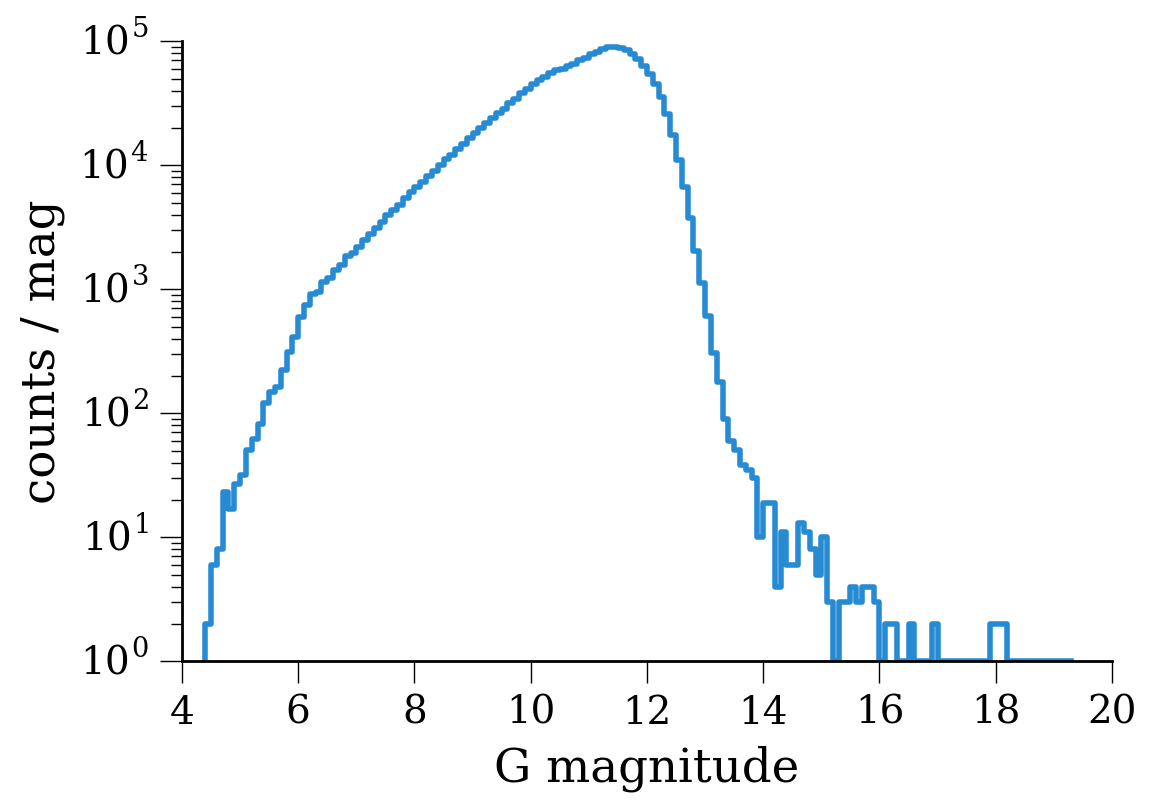

In [8]:
plt.step(data_tgas['val'], data_tgas['n'], lw=2, where='pre', label='TGAS')
plt.yscale('log')
plt.xlabel('G magnitude')
plt.ylabel('counts / mag')
figrc.hide_axis('top right'.split())

**Note**: Creating the luminosity function for the full DR1 required more than 1 min and thefore an async query, which is not handled by this simple query interface.

# Stellar density map

Let's reproduce the stellar density map with **all computations on the server side**

In [9]:
adql = """
select 
    count(*) as n, 
    round(l, 0) as x, 
    round(b, 0) as y
from 
    gaiadr1.tgas_source 
group by x, y
order by x, y
"""
data = gaia.pprint_query(adql)

*ADQL Query*
```mysql

select 
    count(*) as n, 
    round(l, 0) as x, 
    round(b, 0) as y
from 
    gaiadr1.tgas_source 
group by x, y
order by x, y

```


* *Execution time*: 14.9 s

Skipping polishing the projection

(-90, 89)

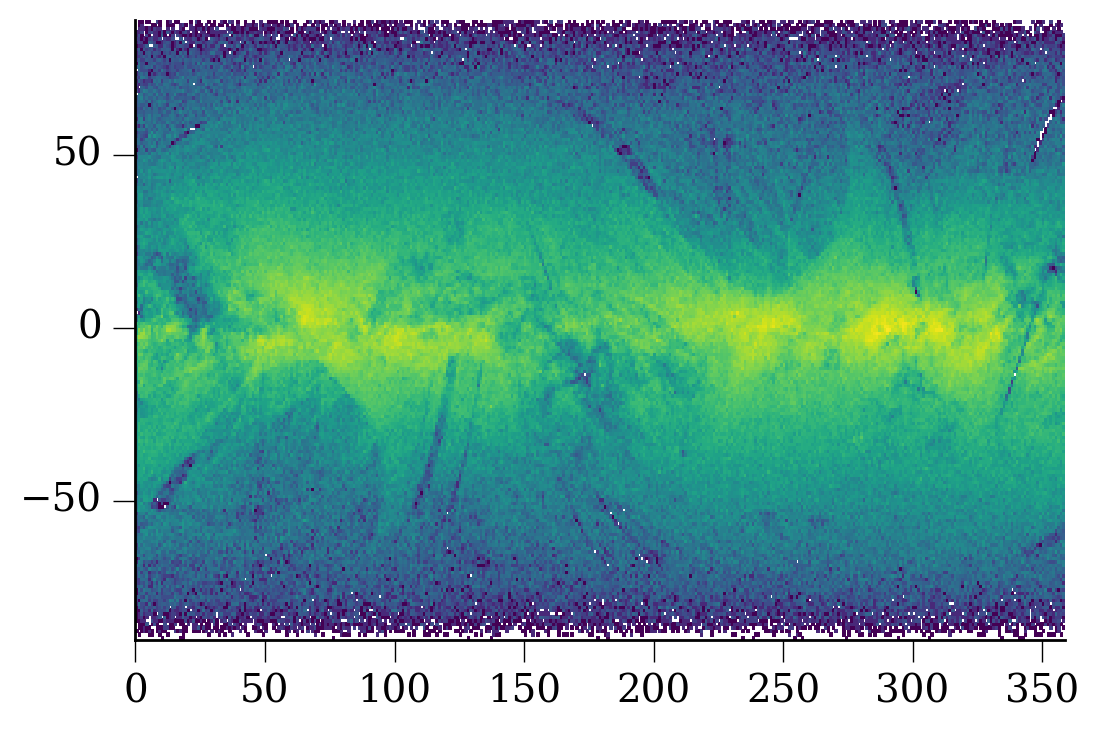

In [10]:
from matplotlib.colors import LogNorm
l = np.arange(0, 360, 1)
b = np.arange(-90, 90, 1)
n = np.zeros((len(l), len(b)))
ix = np.digitize(data['x'], l)
iy = np.digitize(data['y'], b)
n[ix - 1, iy - 1] = data['n']
plt.pcolormesh(l, b, n.T, cmap=plt.cm.viridis, norm=LogNorm())
figrc.hide_axis('top right'.split())
plt.xlim(l.min(), l.max())
plt.ylim(b.min(), b.max())

# Query around a position

In [11]:
adql = """
select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',10.6847083,41.26875,2) )=1  
group by latitude, longitude
order by latitude, longitude
"""
data = gaia.pprint_query(adql)

*ADQL Query*
```mysql

select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',10.6847083,41.26875,2) )=1  
group by latitude, longitude
order by latitude, longitude

```


* *Execution time*: 4.92 s

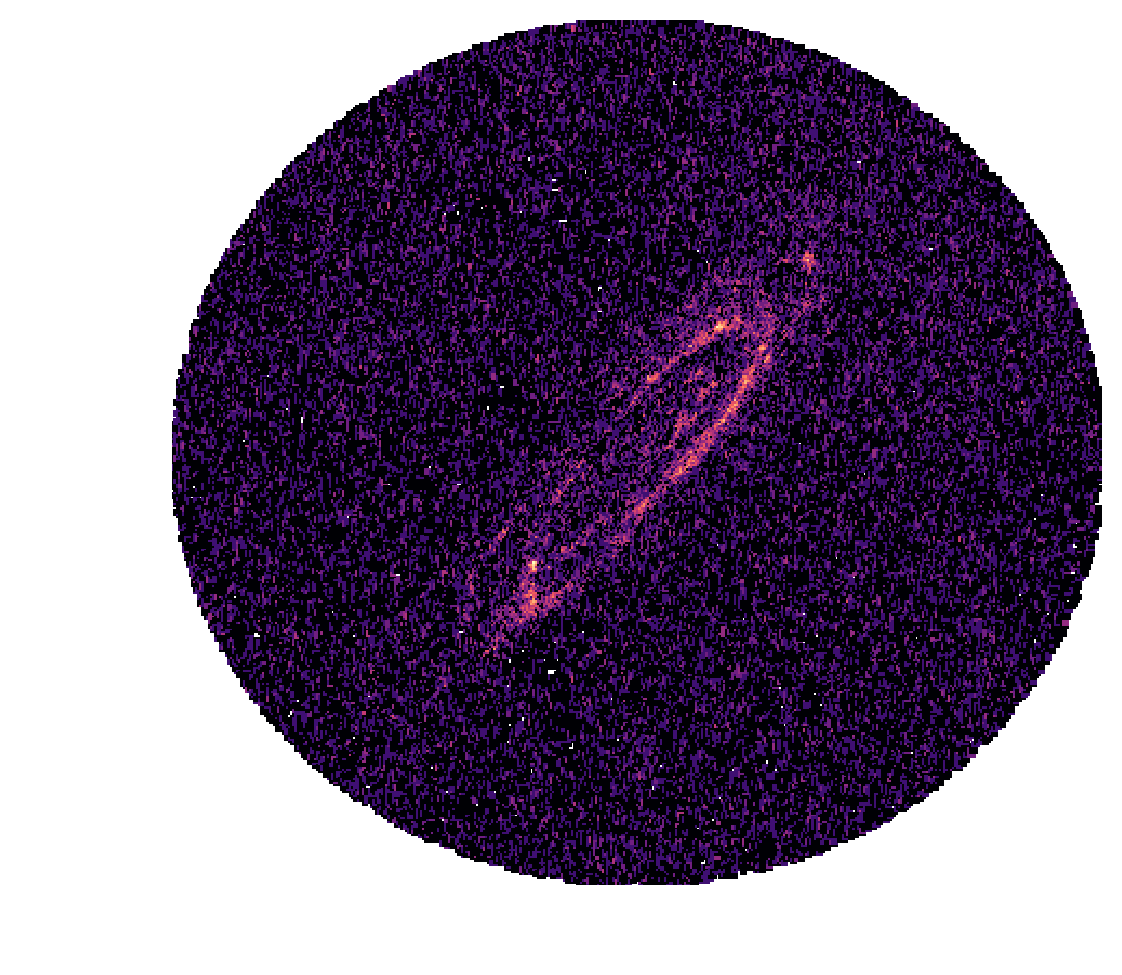

In [12]:
plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(data['latitude'], data['longitude'], c=data['n'], 
            edgecolor='None', s=6, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(data['latitude'].min(), data['latitude'].max())
plt.ylim(data['longitude'].min(), data['longitude'].max())
plt.axis('off');

*ADQL Query*
```mysql

select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',23.4621,30.6599417,0.5) )=1  
group by latitude, longitude
order by latitude, longitude

```


* *Execution time*: 694 ms

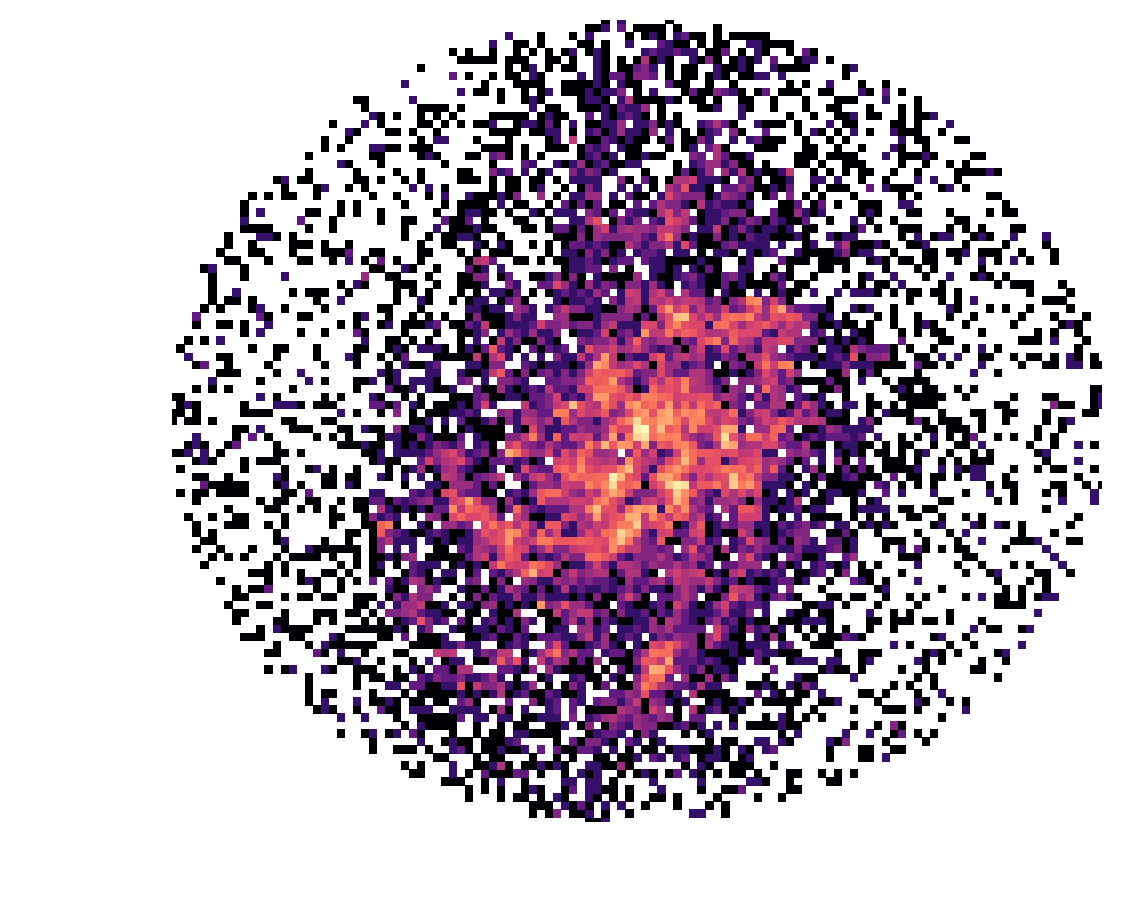

In [13]:
adql = """
select 
    count(*) as n, 
    round(l, 2) as latitude, 
    round(b, 2) as longitude
from 
    gaiadr1.gaia_source 
where 
    contains(point('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),
             circle('ICRS',23.4621,30.6599417,0.5) )=1  
group by latitude, longitude
order by latitude, longitude
"""
data = gaia.pprint_query(adql)
plt.figure(figsize=(6,6))
plt.subplot(111, aspect=1)
plt.scatter(data['latitude'], data['longitude'], c=data['n'], 
            edgecolor='None', s=9, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='s'
           )
plt.xlim(data['latitude'].min(), data['latitude'].max())
plt.ylim(data['longitude'].min(), data['longitude'].max())
plt.axis('off');

# Color-magnitude diagram of TGAS

In [14]:
adql = """
select 
    count(*) as n,
    floor((hip.bt_mag - hip.vt_mag) / 0.01) * 0.01 as color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 as mag
from 
    gaiadr1.tgas_source as gaia
inner join 
    public.tycho2 as hip
    on gaia.hip = hip.hip
where 
    gaia.parallax / gaia.parallax_error >= 5 
    and (2.5/log(10)) * (gaia.phot_g_mean_flux_error / gaia.phot_g_mean_flux) <= 0.05
group by color, mag
"""
data = gaia.pprint_query(adql)

*ADQL Query*
```mysql

select 
    count(*) as n,
    floor((hip.bt_mag - hip.vt_mag) / 0.01) * 0.01 as color,
    floor((gaia.phot_g_mean_mag + 5*log10(gaia.parallax)-10) / 0.05) * 0.05 as mag
from 
    gaiadr1.tgas_source as gaia
inner join 
    public.tycho2 as hip
    on gaia.hip = hip.hip
where 
    gaia.parallax / gaia.parallax_error >= 5 
    and (2.5/log(10)) * (gaia.phot_g_mean_flux_error / gaia.phot_g_mean_flux) <= 0.05
group by color, mag

```


* *Execution time*: 5.43 s

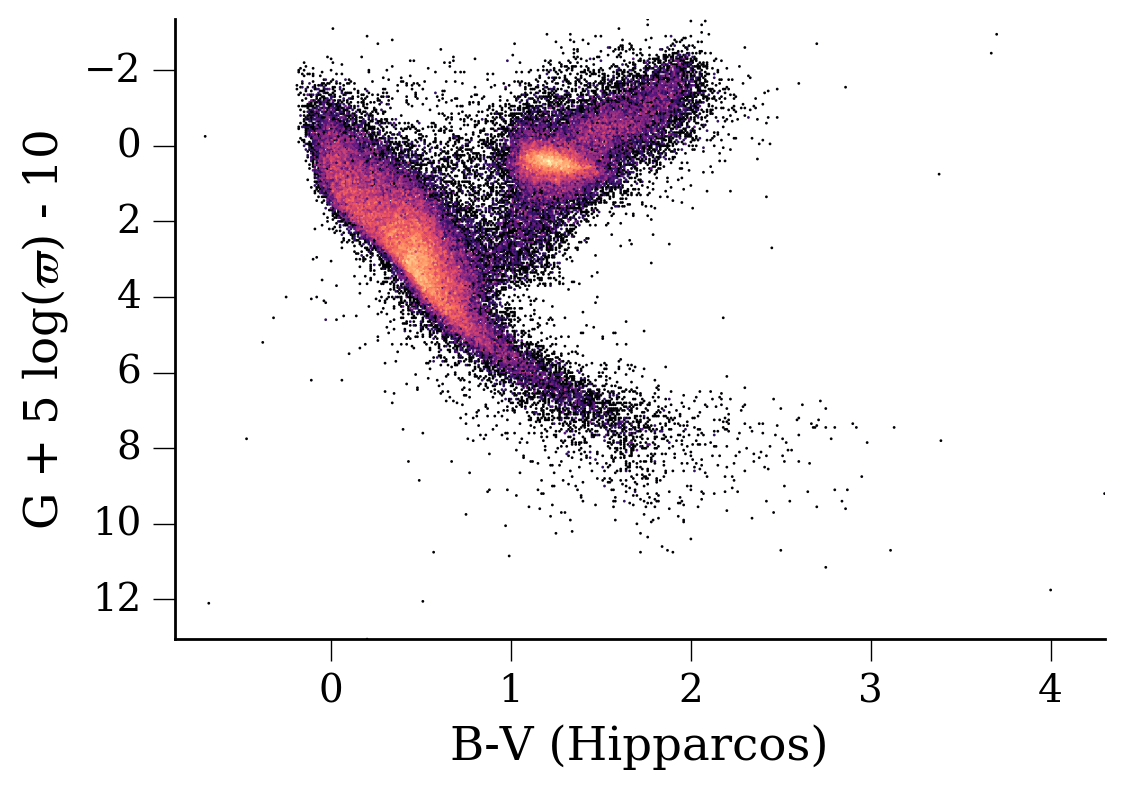

In [15]:
plt.scatter(data['color'], data['mag'], c=data['n'], 
            edgecolor='None', s=1, rasterized=True, norm=LogNorm(),
            cmap=plt.cm.magma, marker='o'
           )
plt.xlim(data['color'].min(), data['color'].max())
plt.ylim(data['mag'].max(), data['mag'].min())
plt.xlabel('B-V (Hipparcos)')
plt.ylabel(r'G + 5 log($\varpi$) - 10')
figrc.hide_axis('top right'.split())

# Testing TAPVizieR

In [16]:
adql = """
select top 100
    gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
    hip."B-V"
from 
    "I/337/tgas" as gaia
inner join 
    "I/311/hip2" as hip
    on gaia.hip = hip.HIP
where
    gaia.parallax/gaia.parallax_error >= 5 AND
    hip.Plx/hip.e_Plx >= 5 AND
    hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
    (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05
"""

vizier = TAPVizieR()
result = vizier.pprint_query(adql)
result

*ADQL Query*
```mysql

select top 100
    gaia.source_id, gaia.hip,
    gaia.phot_g_mean_mag+5*log10(gaia.parallax)-10 as g_mag_abs_gaia,
    gaia.phot_g_mean_mag+5*log10(hip.plx)-10 as g_mag_abs_hip,
    hip."B-V"
from 
    "I/337/tgas" as gaia
inner join 
    "I/311/hip2" as hip
    on gaia.hip = hip.HIP
where
    gaia.parallax/gaia.parallax_error >= 5 AND
    hip.Plx/hip.e_Plx >= 5 AND
    hip."e_B-V" > 0.0 and hip."e_B-V" <= 0.05 AND
    (2.5/log(10))*(gaia.phot_g_mean_flux_error/gaia.phot_g_mean_flux) <= 0.05

```


* *Execution time*: 609 ms

source_id [1],hip [1],g_mag_abs_gaia [1],g_mag_abs_hip [1],B-V [1]
,,mag,mag,mag
int64,int32,float64,float64,float64
2699288848483505792,105933,2.00766679476,1.84399860983,0.336
2699301561586417920,105888,3.92865703631,3.79640320555,0.572
2699385811665187328,106534,6.72957188478,6.46376807748,1.204
2699857124195918336,106279,2.95057772639,2.92610251214,0.579
2700378120909610368,107587,6.53962642638,6.27897941385,1.055
2700417187931661696,107317,9.2643156361,9.20411077861,1.522
2700956635825687424,107924,6.40329214521,6.30953029655,1.1
2701125857535070336,106783,1.6133281367,1.49842822209,0.046
